<a href="https://colab.research.google.com/github/Samy-Annasri/ReverseForecasAttack/blob/main/ReverseForecasAttack.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## IMPORT

In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2]:
import sys
import os

def in_colab():
    return 'google.colab' in sys.modules

if in_colab():
    repo_name = "ReverseForecasAttack"
    ipynb_name = "genetic_algorithm_adv.ipynb"
    cwd = os.getcwd()
    basename = os.path.basename(cwd)

    if basename != repo_name:
        if not os.path.exists(repo_name):
            !git clone https://github.com/Samy-Annasri/ReverseForecasAttack.git
        %cd {repo_name}
        %rm {ipynb_name}



Cloning into 'ReverseForecasAttack'...
remote: Enumerating objects: 60, done.
remote: Counting objects: 100% (60/60), done.
remote: Compressing objects: 100% (44/44), done.
remote: Total 60 (delta 22), reused 36 (delta 8), pack-reused 0 (from 0)
Receiving objects: 100% (60/60), 944.15 KiB | 11.38 MiB/s, done.
Resolving deltas: 100% (22/22), done.
/content/ReverseForecasAttack


In [3]:
import sys

# Suppose que tu as fait avant :
# from utils.setup_google_stock_dataset import prepare_stock_dataset

# Supprime la fonction du namespace courant
if 'prepare_stock_dataset' in globals():
    del globals()['prepare_stock_dataset']

# Supprime aussi le module du cache sys.modules (optionnel)
module_name = 'utils.setup_google_stock_dataset'
if module_name in sys.modules:
    del sys.modules[module_name]


## NORMAL LSTM

In [4]:
google_data = pd.read_csv("data/HistoricalData_1747091015337.csv")
google_data['Date'] = pd.to_datetime(google_data['Date'])
google_data = google_data.sort_values(by='Date')

In [5]:
from utils.setup_google_stock_dataset import prepare_stock_dataset
sequence_length = 30
result = prepare_stock_dataset(google_data)

train_loader = result['train_loader']
test_loader = result['test_loader']
train_size = result['train_size']
min_max = result['min_max']
dates = result['dates']
price_min, price_max = min_max['Close/Last']

/content/ReverseForecasAttack/utils/setup_google_stock_dataset.py:54: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  X = torch.tensor(X)  # (N, sequence_length, num_features)


In [6]:
from utils.train_model import train_model
from models.lstm import SimpleLSTM
model_google = SimpleLSTM(input_size=5, hidden_size=64, output_size=1, num_layers=2)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model_google.parameters(), lr=0.001)
num_epochs = 10
train_model(model_google, loss_fn, optimizer, num_epochs, train_loader)

Epoch [1/10], Train Loss: 0.0363
Epoch [2/10], Train Loss: 0.0051
Epoch [3/10], Train Loss: 0.0014
Epoch [4/10], Train Loss: 0.0011
Epoch [5/10], Train Loss: 0.0010
Epoch [6/10], Train Loss: 0.0010
Epoch [7/10], Train Loss: 0.0009
Epoch [8/10], Train Loss: 0.0010
Epoch [9/10], Train Loss: 0.0010
Epoch [10/10], Train Loss: 0.0009


In [7]:
from utils.google_eval import evaluate_model_google
results = evaluate_model_google(model_google, test_loader, dates, train_size)

real_values = results['real_values']
predicted_values = results['predicted_values']
test_dates = results['test_dates']

In [8]:
# Computes scalar similarity (cosine similarity) between true and predicted values.
# Higher values indicate that adversarial predictions remain directionally aligned
# with the true values, suggesting stealthy and rational attacks!
def scalar_similarity(y_true, y_pred):
    numerator = np.dot(y_true, y_pred)
    denominator = np.linalg.norm(y_true) * np.linalg.norm(y_pred)
    if denominator == 0:
        return 0.0
    return numerator / denominator

In [9]:
# Creation of the tab result for plotting adversial attack result
models = ['LSTM']
metrics = ['MAE', "RMSE", 'SIM']

row_index = pd.MultiIndex.from_product([models, metrics], names=['Model', 'Metric'])

attacks = ['NA','FGSM']
epsilons = {
    'NA': [0],
    'FGSM':[0.01,0.1,0.2],
}

col_tuples = []
for atk, eps_list in epsilons.items():
    for eps in eps_list:
        col_tuples.append((atk, f"{eps:.2f}"))

col_index = pd.MultiIndex.from_tuples(col_tuples, names=['Attack', 'ε'])

res_tab = pd.DataFrame(index=row_index, columns=col_index, dtype=float)

print(res_tab)

Attack         NA FGSM          
ε            0.00 0.01 0.10 0.20
Model Metric                    
LSTM  MAE     NaN  NaN  NaN  NaN
      RMSE    NaN  NaN  NaN  NaN
      SIM     NaN  NaN  NaN  NaN


LSTM | NA – Epsilon 0.00 – MAE: 5.9163 | SIM: 0.9995


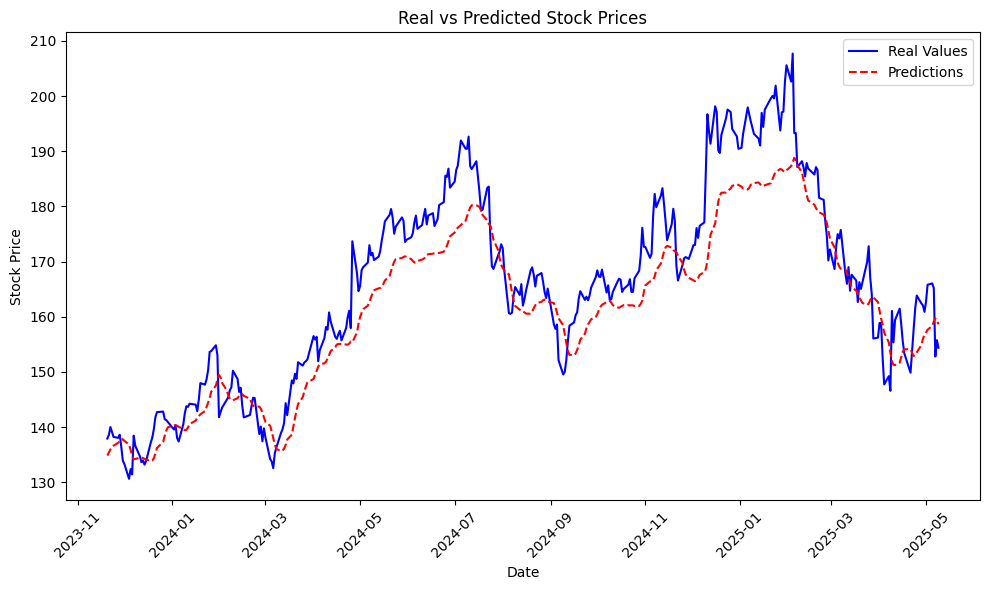

In [10]:
from utils.log_and_plot import log_and_plot_predictions
# Denormalize
true_values_denorm = real_values * (price_max - price_min) + price_min
predictions_denorm = predicted_values * (price_max - price_min) + price_min

log_and_plot_predictions(
    true_values=true_values_denorm,
    predictions=predictions_denorm,
    test_dates=test_dates,
    true_values_rolling=None,
    predictions_rolling=None,
    model_name='LSTM',
    attack_name='NA',
    epsilon=0.00,
    res_tab=res_tab,
    similarity_fn=scalar_similarity,
    google=True
)

In [11]:
display(res_tab)

Attack              NA FGSM          
ε                 0.00 0.01 0.10 0.20
Model Metric                         
LSTM  MAE     5.916276  NaN  NaN  NaN
      RMSE    7.240919  NaN  NaN  NaN
      SIM     0.999454  NaN  NaN  NaN

## REVERSE LSTM

In [12]:
from utils.setup_google_stock_dataset import prepare_stock_dataset
google_data_reversed = google_data[::-1].reset_index(drop=True)
print(google_data_reversed.head())
result_rev = prepare_stock_dataset(google_data_reversed)
train_loader_rev = result_rev['train_loader']
test_loader_rev = result_rev['test_loader']
train_size_rev = result['train_size']
min_max_rev = result['min_max']
dates_rev = result_rev['dates']
print(dates_rev)
price_min_rev, price_max_rev = min_max['Close/Last']


        Date Close/Last    Volume      Open     High        Low
0 2025-05-09    $154.38  22871040   $155.55  $156.43    $153.83
1 2025-05-08    $155.75  38387510   $155.92  $157.41    $154.10
2 2025-05-07    $152.80  78900430   $166.07  $166.99  $149.4901
3 2025-05-06    $165.20  10691950   $163.96  $166.74    $163.13
4 2025-05-05    $166.05  15309340  $164.515  $167.10    $164.47
[Timestamp('2025-03-27 00:00:00'), Timestamp('2025-03-26 00:00:00'), Timestamp('2025-03-25 00:00:00'), Timestamp('2025-03-24 00:00:00'), Timestamp('2025-03-21 00:00:00'), Timestamp('2025-03-20 00:00:00'), Timestamp('2025-03-19 00:00:00'), Timestamp('2025-03-18 00:00:00'), Timestamp('2025-03-17 00:00:00'), Timestamp('2025-03-14 00:00:00'), Timestamp('2025-03-13 00:00:00'), Timestamp('2025-03-12 00:00:00'), Timestamp('2025-03-11 00:00:00'), Timestamp('2025-03-10 00:00:00'), Timestamp('2025-03-07 00:00:00'), Timestamp('2025-03-06 00:00:00'), Timestamp('2025-03-05 00:00:00'), Timestamp('2025-03-04 00:00:00'), Tim

In [13]:
model_google_rev = SimpleLSTM(input_size=5, hidden_size=64, output_size=1, num_layers=2)
optimizer_rev = torch.optim.Adam(model_google_rev.parameters(), lr=0.001)

train_model(model_google_rev, loss_fn, optimizer_rev, num_epochs, train_loader_rev)

Epoch [1/10], Train Loss: 0.0725
Epoch [2/10], Train Loss: 0.0126
Epoch [3/10], Train Loss: 0.0026
Epoch [4/10], Train Loss: 0.0021
Epoch [5/10], Train Loss: 0.0018
Epoch [6/10], Train Loss: 0.0017
Epoch [7/10], Train Loss: 0.0015
Epoch [8/10], Train Loss: 0.0015
Epoch [9/10], Train Loss: 0.0015
Epoch [10/10], Train Loss: 0.0014


[Timestamp('2021-10-26 00:00:00'), Timestamp('2021-10-25 00:00:00'), Timestamp('2021-10-22 00:00:00'), Timestamp('2021-10-21 00:00:00'), Timestamp('2021-10-20 00:00:00'), Timestamp('2021-10-19 00:00:00'), Timestamp('2021-10-18 00:00:00'), Timestamp('2021-10-15 00:00:00'), Timestamp('2021-10-14 00:00:00'), Timestamp('2021-10-13 00:00:00'), Timestamp('2021-10-12 00:00:00'), Timestamp('2021-10-11 00:00:00'), Timestamp('2021-10-08 00:00:00'), Timestamp('2021-10-07 00:00:00'), Timestamp('2021-10-06 00:00:00'), Timestamp('2021-10-05 00:00:00'), Timestamp('2021-10-04 00:00:00'), Timestamp('2021-10-01 00:00:00'), Timestamp('2021-09-30 00:00:00'), Timestamp('2021-09-29 00:00:00'), Timestamp('2021-09-28 00:00:00'), Timestamp('2021-09-27 00:00:00'), Timestamp('2021-09-24 00:00:00'), Timestamp('2021-09-23 00:00:00'), Timestamp('2021-09-22 00:00:00'), Timestamp('2021-09-21 00:00:00'), Timestamp('2021-09-20 00:00:00'), Timestamp('2021-09-17 00:00:00'), Timestamp('2021-09-16 00:00:00'), Timestamp('20

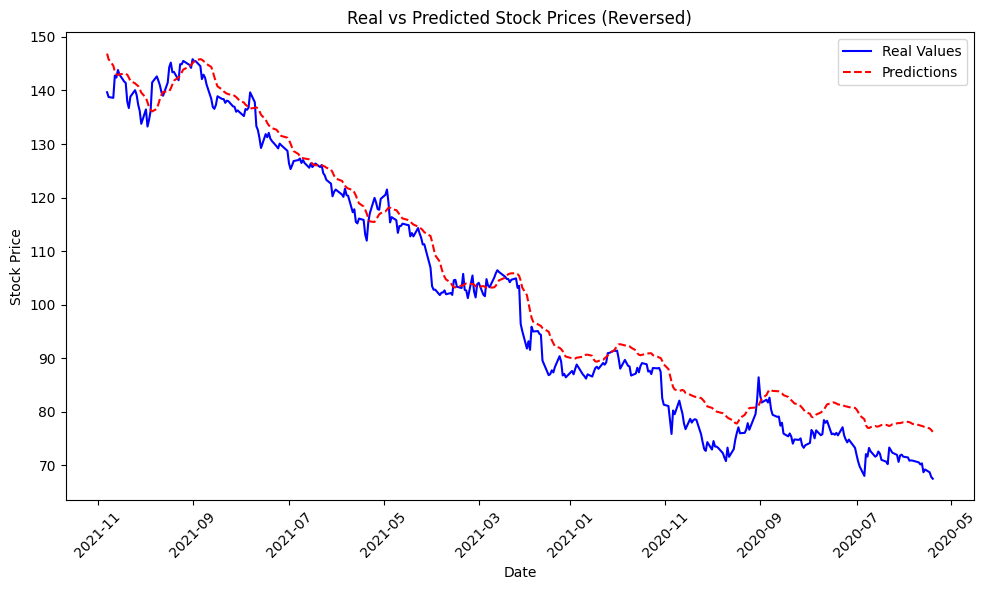

In [14]:
results_rev = evaluate_model_google(model_google_rev, test_loader_rev, dates_rev, train_size_rev)

real_values_rev = results_rev['real_values']
predicted_values_rev = results_rev['predicted_values']
test_dates_rev = results_rev['test_dates']
print(test_dates_rev)
true_values_denorm_rev = real_values_rev * (price_max_rev - price_min_rev) + price_min_rev
predictions_denorm_rev = predicted_values_rev * (price_max_rev - price_min_rev) + price_min_rev

log_and_plot_predictions(
    true_values=true_values_denorm_rev,
    predictions=predictions_denorm_rev,
    test_dates=test_dates_rev,
    true_values_rolling=None,
    predictions_rolling=None,
    model_name='LSTM',
    attack_name='REV',
    epsilon=0.00,
    res_tab=res_tab,
    similarity_fn=scalar_similarity,
    google=True,
    reverse=True
)

In [18]:
from attack.fgsm import fgsm_attack

In [17]:
print(google_data.head())
print(google_data_reversed.head())

           Date Close/Last    Volume      Open      High       Low
1254 2020-05-13   $67.4665  36251700  $68.8525  $69.2741    $66.42
1253 2020-05-14   $67.8065  32061540   $66.751   $67.871  $66.1955
1252 2020-05-15   $68.6595  34154940    $67.50   $68.724    $66.95
1251 2020-05-18    $69.197  36479280  $68.0875  $69.6163  $67.7125
1250 2020-05-19   $68.6743  25612980  $69.3499    $69.60  $68.6743
        Date Close/Last    Volume      Open     High        Low
0 2025-05-09    $154.38  22871040   $155.55  $156.43    $153.83
1 2025-05-08    $155.75  38387510   $155.92  $157.41    $154.10
2 2025-05-07    $152.80  78900430   $166.07  $166.99  $149.4901
3 2025-05-06    $165.20  10691950   $163.96  $166.74    $163.13
4 2025-05-05    $166.05  15309340  $164.515  $167.10    $164.47
